# Earthquake-LANL Data Wrangling and Exploration
The purpose of this notebook is to adequately understand, describe, and explore the lanl data set that will be used in this project.

In [2]:
import os
while os.path.basename(os.getcwd()) != 'Synthetic_Data_GAN_Capstone':
    os.chdir('..')
from utils.data_loading import load_raw_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Importing data
Note that I have written a helper function to load in the desired data set. This data set is much larger than the other data sets, and could take a significant amount of time to load. If you have not already downloaded
the data sets to the appropriate directory, this can be done simply by running the following code:

In [3]:
%%time
lanl = load_raw_dataset('lanl')
lanl.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


### Inspecting the data

In [4]:
lanl.shape

(629145480, 2)

Wow, that is a really long data set. At least we only have one feature to worry about...

### Visualizing the data

In [5]:
train_acoustic_data_small = lanl['acoustic_data'].values[::50]
train_time_to_failure_small = lanl['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

Sampling only 2% of the inputs against the outputs does a good job visualizing the data. As can be seen here, there are approximately 16 distinct earthquakes in this data set, and it appears that the data increases in oscillations as it approaches the earthquake occurrence. There is a very large spike right before the earthquake.

Let's take a look at some of the test samples

In [22]:
import glob
test_paths = glob.glob('data/lanl/test/*.csv')
test_size = len(test_paths)
test = np.empty((test_size, 150000))
for i, x in enumerate(test_paths):
    test[i] = np.genfromtxt(x, skip_header=1)
    if i>10:
        break

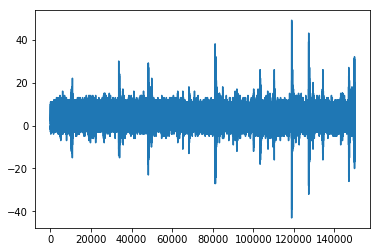

In [23]:
plt.plot(test[0])

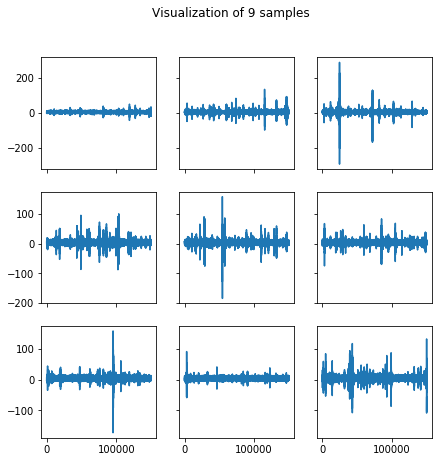

In [37]:
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(7, 7))
# plt.title('Visualization of 9 test points')
# plt.xlabel('Index')
# plt.ylabel('Acoustic Signal')
for i in range(3):
    for j in range(3):
        ax[i, j].plot(test[i+j*3])
fig.suptitle('Visualization of 9 samples')
plt.show()

The challenge of this problem is to predict the time to failure for a very short chunk of data (150,000 data points), which corresponds to not a lot of wall-to-wall time.

In [41]:
print("Total elapsed duration of one sample:", str(round(lanl.time_to_failure[0]-lanl.time_to_failure[150000], 4))+"s")

Total elapsed duration of one sample: 0.0383s


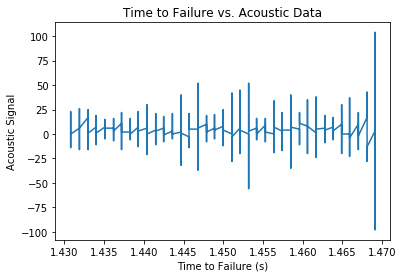

In [43]:
plt.plot(lanl.time_to_failure[0:150000], lanl.acoustic_data[0:150000])
plt.title('Time to Failure vs. Acoustic Data')
plt.xlabel('Time to Failure (s)')
plt.ylabel('Acoustic Signal')
plt.show()

This is fairly interesting. If we plot with time to failure as the x-axis, rather than the index, it can be seen that the time to failure is not constantly decreasing, but rather sampled in chunks. This will make predictions more difficult!

While neural networks are great at handling unstructured data, using samples of size 150,000 seems a bit unwieldy. I propose downsampling the input by a factor of 10 with the hopes of not losing much information, but significantly reducing training time and model complexity.

### Transforming the data
Additionally, since the actual raw signal has very little meaning, but rather the variation between raw signals, I propose transforming the raw acoustic data signal to a rolling 50 RMS (root mean squared). If we transform the data to a rolling 50 RMS, and then downsample, we should still be keeping most of the useful information.

In [50]:
%%time
new_len = (len(lanl.acoustic_data)-50)//10
ss = np.empty((new_len, 50))
ss.shape
for i in range(new_len):
    ss[i] = lanl.acoustic_data[(i*10):(i*10)+50]

In [51]:
train_rms = np.log(np.sqrt(np.square(ss).sum(axis=1)/50 - np.square(ss.sum(axis=1)/50)))

Much better. Let's take a quick look at our new data, and save it for later. We will need to center and standardize our data before feeding it to a neural network, but will plan on doing that in the training section.

In [52]:
pd.DataFrame(train_rms).describe()

,0
count,6.291454e+07
mean,6.505296e+00
std,9.662408e+00
min,2.782086e+00
25%,5.134199e+00
50%,5.546170e+00
75%,6.122091e+00
max,2.821348e+03


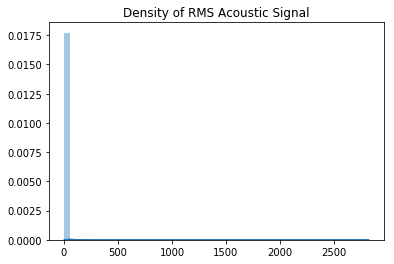

In [57]:
sns.distplot(train_rms)
plt.title("Density of RMS Acoustic Signal")
plt.show()

This data is extremely right-skewed. It may be necessary to perform some kind of box-cox transformation when attempting to fit a model.

Let's perform the same time-series transformation on our labels:

In [79]:
train_targets = lanl.time_to_failure[::10]
train_targets = np.array(train_targets[5:])
len(train_targets) == len(train_rms)

True

In [69]:
np.corrcoef(lanl.acoustic_data, lanl.time_to_failure)

array([[ 1.00000000e+00, -7.61958861e-04],
       [-7.61958861e-04,  1.00000000e+00]])

In [67]:
np.corrcoef(train_rms, train_targets)

array([[ 1.        , -0.05782275],
       [-0.05782275,  1.        ]])

At least in a linear sense, it appears our transformation has significantly increased the correlation between input and output.

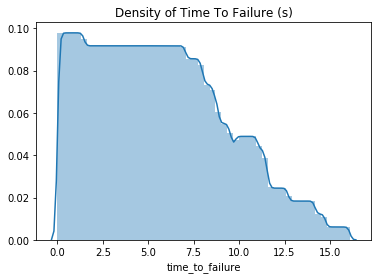

In [66]:
sns.distplot(train_targets)
plt.title("Density of Time To Failure (s)")
plt.show()

We have a lot fewer labels at the higher ends of the time_to_failure spectrum. It will be interesting to see if these are more difficult to predict.

It will also be useful to know which earthquake is where, so that we can perform cross-validation by earthquake, as well as prevent ourselves from training on a sample that straddles an earthquake occurrence, which would make no sense.

In [81]:
eq_indices = np.empty((len(train_targets)))
curr_eq = 1
eq_indices[0] = curr_eq
for i in range(1, len(train_targets)):
    if train_targets[i]>train_targets[i-1]:
        curr_eq += 1
    eq_indices[i] = curr_eq

Now we can do a little bit of descriptive statistics by earthquake in order to compare them:

In [91]:
comb = pd.concat([pd.DataFrame(train_targets), pd.DataFrame(eq_indices)], axis=1)
comb.columns = ['TTF','EQ']
comb.groupby('EQ').agg({'EQ': ['count'], 'TTF': [max, min]})

EQ      TTF          
        count      max       min
EQ                              
1.0    565653   1.4691  0.000795
2.0   4442930  11.5408  0.000695
3.0   5459148  14.1806  0.000795
4.0   3409510   8.8567  0.001095
5.0   4886936  12.6940  0.000595
6.0   3101081   8.0555  0.001096
7.0   2717696   7.0590  0.000495
8.0   6200933  16.1074  0.000696
9.0   3043737   7.9056  0.000196
10.0  3710156   9.6371  0.000496
11.0  4399103  11.4264  0.000196
12.0  4244275  11.0242  0.000096
13.0  3398860   8.8281  0.000096
14.0  3297689   8.5660  0.000896
15.0  5679103  14.7518  0.000596
16.0  3641753   9.4595  0.000596
17.0   715980  11.6186  9.759796

### Generator to produce samples for training
I have put together a generator so that I will be able to easily pull out training samples of size 14995 (original size of 150000, less 50 for the rolling 50 RMS, downsampled by a factor of 10). Let's take a peek at it:

In [93]:
from utils.my_classes_tf import DataGenerator, ValDataGenerator
train_gen = DataGenerator(data=train_rms.reshape(-1,1),
                          targets=train_targets,
                          indices=eq_indices,
                          min_index=0,
                          max_index=None,
                          batch_size=64,
                          lookback=14995,
                          offset=15000,
                          shuffle_start=True,
                          shuffle_feed=True)

In [96]:
train_gen[0][0].shape

(64, 14995, 1)

In [97]:
train_gen[0][1].shape

(64,)

I programmed a few helpful features into this generator, namely:
1. Can handle data of variable size (both length and width, if we wanted to add features or change downsample rate)
2. Can control whether we want to have overlaps in our data when we draw samples, via the offset parameter. For example, if the length of our data (lookback) is 15000, but we offset by only 1500, we will effectively train on 10 times the number of samples per epoch (although there will be a significant amount of overlap, which could result in overfitting).
3. Can control whether to shuffle the starting point of the data, as well as shuffle the data itself.
4. Method called "adjust_cross_eqs" prevents drawing samples that span across an earthquake failure.
5. Uses the keras.utils.Sequence, which supports using a CPU to draw samples in parallel to GPU training.

### Store the cleaned data for future use
Lastly, let's save our transformed data in a serialized manner so that we can easily re-import later for training.

In [80]:
import pickle as pkl
with open('downloads/lanl/processed/train_data.pkl', 'wb') as f:
    pkl.dump(train_rms, f)
with open('downloads/lanl/processed/train_targets.pkl', 'wb') as f:
    pkl.dump(train_targets, f)